In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# 1. Adathalmaz előkészítése

Olvasd be a movies_prep és a ratings_sample csv fájlokat. Előbbi az egyes filmek kategóriáját tartalmazza, utóbbi pedig a filmekre vonatkozó felhasználói értékeléseket.

Normalizáld a felhasználók egyes értékeléseit az adott felhasználó átlagos értékelésével (adott felhasználó minden értékeléséből kivonod, hogy az összes általa értékelt filmen mi volt az átlagos értékelése) - megszokott értékelési tendenciájához képest jobban / kevésbé kedveli.

A filmkategóriáknál (genre_) a 0 értékeket helyettesítsd nan értékkel majd szorozd rá az adott film normalizált értékelését (rating). Ezután állítsd elő, hogy az egyes felhasználók az egyes kategóriákat átlagosan mennyire szeretik, hogy a klaszterező algoritmus számára megfelelő formába kerüljön.

In [2]:
movies = pd.read_csv('movies_prep.csv')
ratings = pd.read_csv('ratings_sample.csv')

In [3]:
movies.head()

,movieId,title,genres,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,...,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,123759,3243,3.0,1017030084
1,104903,594,2.0,1082736879
2,14310,2953,4.0,992503206
3,62120,3917,1.0,1460077438
4,9650,98809,1.0,1500832106


In [3]:
# Felhasználók átlagos értékeléseinek számítása
user_avg_ratings = ratings.groupby('userId')['rating'].mean().reset_index()
user_avg_ratings.columns = ['userId', 'avg_rating']

# Normalizálás
ratings = ratings.merge(user_avg_ratings, on='userId')
ratings['normalized_rating'] = ratings['rating'] - ratings['avg_rating']


print(ratings)

        userId  movieId  rating   timestamp  avg_rating  normalized_rating
0       123759     3243     3.0  1017030084      3.6875            -0.6875
1       123759     3717     3.0  1039241069      3.6875            -0.6875
2       123759     3793     3.0  1016951077      3.6875            -0.6875
3       123759     1917     4.0  1016953414      3.6875             0.3125
4       123759     1073     4.0  1042406090      3.6875             0.3125
...        ...      ...     ...         ...         ...                ...
481577   10590     1304     5.0   956048696      5.0000             0.0000
481578  145007     6711     5.0  1345060476      5.0000             0.0000
481579  145443     3250     3.5  1137519739      3.5000             0.0000
481580   10238      589     3.0  1135579834      3.0000             0.0000
481581   45062     7458     5.0  1471443388      5.0000             0.0000

[481582 rows x 6 columns]


In [4]:
print(ratings[ratings['movieId']==780])

        userId  movieId  rating   timestamp  avg_rating  normalized_rating
25      104903      780     1.5  1082736094    3.350000          -1.850000
1127     30150      780     3.5  1134401748    2.555556           0.944444
2853    140472      780     3.0  1453082280    3.174419          -0.174419
3472    120377      780     2.0   837435775    3.600000          -1.600000
5346     19835      780     2.0  1117136274    3.782609          -1.782609
...        ...      ...     ...         ...         ...                ...
480547  141664      780     5.0  1566336647    5.000000           0.000000
480925   43535      780     4.0   865005962    4.000000           0.000000
481331    7625      780     3.5  1078798722    3.500000           0.000000
481389   36392      780     4.0   859995167    4.000000           0.000000
481467   25947      780     3.0   854268044    3.000000           0.000000

[974 rows x 6 columns]


In [8]:
movies.iloc[:, 3:23]

,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
62419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
62420,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
62421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# 0 értékek cseréje NaN-re
movies.iloc[:, 3:] = movies.iloc[:, 3:].replace(0, np.nan)

# filmre adott átlagos normalizált értékelés
movie_norm_avg_ratings = ratings.groupby('movieId')['normalized_rating'].mean().reset_index()
movie_norm_avg_ratings.columns = ['movieId', 'norm_avg_rating']

# Normalizálás
ratings = ratings.merge(movie_norm_avg_ratings, on='movieId')
movies = movies.merge(movie_norm_avg_ratings, on='movieId')

In [10]:
ratings

,userId,movieId,rating,timestamp,avg_rating,normalized_rating,norm_avg_rating
0,123759,3243,3.0,1017030084,3.701149,-0.701149,-0.726925
1,70614,3243,3.0,1013988450,4.154762,-1.154762,-0.726925
2,70479,3243,2.5,1180473804,3.630435,-1.130435,-0.726925
3,40209,3243,2.0,1027127019,3.370968,-1.370968,-0.726925
4,53136,3243,2.0,976164607,3.751938,-1.751938,-0.726925
...,...,...,...,...,...,...,...
2999995,10861,169816,5.0,1488825065,5.000000,0.000000,0.000000
2999996,10861,129223,5.0,1488826391,5.000000,0.000000,0.000000
2999997,135508,190011,0.5,1529626890,0.500000,0.000000,0.000000
2999998,39093,144290,2.5,1449680214,2.500000,0.000000,0.000000


In [5]:
movie_cat = movies.iloc[:,:22]

In [12]:
movie_cat

,movieId,title,genres,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,...,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.0,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33630,209121,Adrenalin: The BMW Touring Car Story (2014),Documentary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
33631,209135,Jane B. by Agnès V. (1988),Documentary|Fantasy,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
33632,209143,The Painting (2019),Animation|Documentary,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
33633,209147,The Carpet of Horror (1962),Crime|Horror,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:

movie_cat_and_id = ratings.merge(movie_cat, on='movieId')

In [14]:
movie_cat_and_id

,userId,movieId,rating,timestamp,avg_rating,normalized_rating,norm_avg_rating,title,genres,genre_Adventure,...,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,123759,3243,3.0,1017030084,3.701149,-0.701149,-0.726925,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,70614,3243,3.0,1013988450,4.154762,-1.154762,-0.726925,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70479,3243,2.5,1180473804,3.630435,-1.130435,-0.726925,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40209,3243,2.0,1027127019,3.370968,-1.370968,-0.726925,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53136,3243,2.0,976164607,3.751938,-1.751938,-0.726925,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,10861,169816,5.0,1488825065,5.000000,0.000000,0.000000,Day of the Panther (1988),Action,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2999996,10861,129223,5.0,1488826391,5.000000,0.000000,0.000000,Tarzan's Savage Fury (1952),Action|Adventure,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2999997,135508,190011,0.5,1529626890,0.500000,0.000000,0.000000,Legend of the Naga Pearls (2017),Adventure|Comedy|Fantasy|Romance,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2999998,39093,144290,2.5,1449680214,2.500000,0.000000,0.000000,Another Public Enemy (2005),Action|Drama|Thriller,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
movie_cat_and_id.iloc[:,0:28]

,userId,movieId,rating,timestamp,avg_rating,normalized_rating,norm_avg_rating,title,genres,genre_Adventure,...,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,123759,3243,3.0,1017030084,3.687500,-0.687500,-0.705428,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,146639,3243,3.5,1219027647,3.850000,-0.350000,-0.705428,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96794,3243,4.0,999751274,3.700000,0.300000,-0.705428,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,96947,3243,2.0,1227274103,3.392857,-1.392857,-0.705428,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87688,3243,2.5,1556844296,3.093750,-0.593750,-0.705428,Encino Man (1992),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481577,45149,6855,0.5,1198389378,0.500000,0.000000,0.000000,"Murderous Maids (Blessures assassines, Les) (2...",Drama,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481578,148208,51082,3.5,1238461384,3.500000,0.000000,0.000000,Tyler Perry's Daddy's Little Girls (2007),Comedy|Romance,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481579,44558,61354,4.0,1238615295,4.000000,0.000000,0.000000,College (2008),Comedy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481580,154257,623,4.0,845305801,4.000000,0.000000,0.000000,"Modern Affair, A (1995)",Romance,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:

# Normalizált értékelések szorzása a kategória oszlopokkal
for genre in movie_cat_and_id.columns[9:28]:
    movie_cat_and_id[genre] = movie_cat_and_id.apply(lambda row: row[genre] * row['normalized_rating'], axis=1)



In [11]:
movie_cat_and_id.to_csv('normalized_ratings.csv', index=False)

In [ ]:
movies_cat_and_id = pd.read_csv('normalized_ratings.csv')

In [78]:
# minden személynek a egyes kategóriákhoz rendelt átlag értékelés normalizálva
user_avg_per_category = movie_cat_and_id.groupby('userId').mean().reset_index()
user_avg_per_category

<ipython-input-78-bfcfcf90e4f7>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_avg_per_category = movie_cat_and_id.groupby('userId').mean().reset_index()


,userId,movieId,rating,timestamp,avg_rating,normalized_rating,norm_avg_rating,genre_Adventure,genre_Animation,genre_Children,...,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,1,1260.000000,3.500000,1.147878e+09,3.500000,0.000000e+00,0.451654,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2,2065.333333,4.333333,1.141417e+09,4.333333,2.960595e-16,0.185988,NaN,NaN,NaN,...,-0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,40977.000000,3.958333,1.460576e+09,3.958333,-1.480297e-16,-0.035973,-0.058333,NaN,NaN,...,-0.125000,-0.958333,0.541667,-0.083333,0.041667,NaN,-0.458333,NaN,NaN,NaN
3,4,42966.375000,3.312500,1.573939e+09,3.312500,0.000000e+00,0.062694,-0.062500,NaN,NaN,...,-0.145833,NaN,0.187500,-0.312500,-1.062500,NaN,0.187500,NaN,NaN,NaN
4,5,178.500000,4.000000,8.307865e+08,4.000000,0.000000e+00,-0.024254,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116697,162535,1209.000000,3.500000,9.449635e+08,3.500000,0.000000e+00,0.077931,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116698,162537,2366.000000,4.000000,1.047171e+09,4.000000,0.000000e+00,0.061326,0.000000,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116699,162538,2538.333333,2.333333,1.438782e+09,2.333333,-1.480297e-16,-0.286443,NaN,NaN,NaN,...,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116700,162540,2717.500000,2.750000,1.248858e+09,2.750000,0.000000e+00,-0.339870,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.250000,NaN,NaN,NaN


In [79]:
avg_per_category = user_avg_per_category.drop(['movieId', 'normalized_rating','rating','timestamp','norm_avg_rating','avg_rating'], axis=1)

In [81]:
avg_per_category

,userId,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,2,0.000000,0.0,0.0,0.000000,0.000000,-3.333333e-01,2.960595e-16,0.000000,0.000000,-0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,3,-0.058333,0.0,0.0,-0.458333,0.291667,4.166667e-02,2.083333e-01,-0.145833,0.291667,-0.125000,-0.958333,0.541667,-0.083333,0.041667,0.0,-0.458333,0.0,0.0,0.0
3,4,-0.062500,0.0,0.0,0.520833,-0.312500,-3.125000e-01,1.875000e-01,0.044643,0.000000,-0.145833,0.000000,0.187500,-0.312500,-1.062500,0.0,0.187500,0.0,0.0,0.0
4,5,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116697,162535,0.000000,0.0,0.0,-1.500000,-1.500000,-1.500000e+00,1.500000e+00,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
116698,162537,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
116699,162538,0.000000,0.0,0.0,-0.083333,0.000000,-1.480297e-16,1.666667e-01,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
116700,162540,0.000000,0.0,0.0,-2.250000,0.000000,2.250000e+00,2.250000e+00,2.250000,-2.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.250000,0.0,0.0,0.0


In [80]:
avg_per_category.fillna(0,inplace=True)

In [41]:
# oszlopok összegének a kiszámítása

#column_sums = movies.iloc[:,3:22].sum()

# Kíváncsiak lehetünk az eredményre:
#print(column_sums)

genre_Adventure      -741.838495
genre_Animation      -317.019681
genre_Children       -608.176160
genre_Comedy        -2405.927178
genre_Fantasy        -462.982407
genre_Romance        -752.391148
genre_Drama         -1297.110122
genre_Action        -1375.065054
genre_Crime          -499.829988
genre_Thriller      -1506.171047
genre_Horror        -1801.218973
genre_Mystery        -323.157184
genre_Sci-Fi         -962.075429
genre_IMAX            -45.153689
genre_Documentary     308.538263
genre_War              -6.666387
genre_Musical        -109.262920
genre_Western         -99.240494
genre_Film-Noir        11.112890
dtype: float64


# 2. K-Means klaszterezés

Keresd meg hány klasztert kellene létrehozni a K-Means algoritmussal a felhasználókból (random_state = 42 értékkel). Ezután végezd el a klaszterezést és vond le a következtetést, hogy melyik klaszternek melyik a 3 legjobban és 3 legkevésbé kedvelt filmkategóriája. Melyik kategória befolyásolja legjobban a klaszterezés eredményét?

In [12]:

sse_list = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state = 42)
    kmeans.fit(avg_per_category.iloc[:,1:])

    sse = kmeans.inertia_
    sse_list.append(sse)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
plt.plot(range(1, 10), sse_list, marker='o')

In [82]:
kmeans = KMeans(n_clusters=5, random_state = 42)
kmeans.fit(avg_per_category.iloc[:,1:])
avg_per_category['cluster_5'] = kmeans.predict(avg_per_category.iloc[:,1:])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [83]:
avg_per_category

,userId,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,...,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir,cluster_5
0,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,3
1,2,0.000000,0.0,0.0,0.000000,0.000000,-3.333333e-01,2.960595e-16,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,3
2,3,-0.058333,0.0,0.0,-0.458333,0.291667,4.166667e-02,2.083333e-01,-0.145833,0.291667,...,-0.958333,0.541667,-0.083333,0.041667,0.0,-0.458333,0.0,0.0,0.0,3
3,4,-0.062500,0.0,0.0,0.520833,-0.312500,-3.125000e-01,1.875000e-01,0.044643,0.000000,...,0.000000,0.187500,-0.312500,-1.062500,0.0,0.187500,0.0,0.0,0.0,3
4,5,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116697,162535,0.000000,0.0,0.0,-1.500000,-1.500000,-1.500000e+00,1.500000e+00,0.000000,1.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,4
116698,162537,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,3
116699,162538,0.000000,0.0,0.0,-0.083333,0.000000,-1.480297e-16,1.666667e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,3
116700,162540,0.000000,0.0,0.0,-2.250000,0.000000,2.250000e+00,2.250000e+00,2.250000,-2.250000,...,0.000000,0.000000,0.000000,0.000000,0.0,2.250000,0.0,0.0,0.0,2


In [12]:
group_cluster5 = avg_per_category.iloc[:,1:].groupby('cluster_5').mean().reset_index()

In [13]:
group_cluster5
# 0. cluster Documentary lover

,cluster_5,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,0,-0.625095,0.042997,0.014881,0.079931,-0.052715,0.209076,0.482306,-0.700641,0.249797,-0.143250,-0.071717,0.116245,-0.652558,-0.135077,0.032088,0.108469,0.047381,-0.008159,0.043498
1,1,0.358081,0.320135,0.325462,0.243800,0.324146,0.162940,-0.027692,-0.181340,-0.351493,-0.636671,-0.274219,-0.230233,-0.051908,0.048719,0.017280,0.054587,0.164693,0.025654,-0.016335
2,2,-0.505024,-0.603297,-0.980663,-0.306044,-0.696094,0.043865,0.362382,0.093193,0.272831,0.302470,0.010894,0.146269,0.076235,-0.083610,0.029332,0.155096,-0.240357,0.027465,0.042447
3,3,-0.002296,0.002823,-0.006143,0.003826,-0.002071,0.008982,0.001864,-0.006081,0.009114,0.001794,-0.001834,0.006213,0.003102,-0.000002,0.003411,0.005792,-0.000124,0.001072,0.003172
4,4,0.285066,0.035244,0.000364,-0.581695,0.009722,-0.425574,0.051202,0.374590,0.269160,0.416893,0.014926,0.200745,0.269889,0.082454,-0.001129,0.025097,-0.051985,0.002349,0.041098


In [14]:
# legnagyobb n érték megtalálása
def get_top_n_values_and_columns(row, n):
    top_n_values = row.nlargest(n)
    top_n_columns = top_n_values.index
    return dict(zip(top_n_columns, top_n_values))

# A legnagyobb 3 értékek és oszlopneveik megtalálása
top_3_values_and_columns = group_cluster5.iloc[:,1:].apply(get_top_n_values_and_columns, args=(3,), axis=1)

# Létrehozás egy új DataFrame, amely tartalmazza a legnagyobb 3 értékeket és oszlopneveiket
top_3_df = pd.DataFrame(top_3_values_and_columns.tolist(), index=group_cluster5.iloc[:,1:].index)




In [15]:
top_3_df

,genre_Drama,genre_Crime,genre_Romance,genre_Adventure,genre_Children,genre_Fantasy,genre_Thriller,genre_Mystery,genre_Action
0,0.482306,0.249797,0.209076,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.358081,0.325462,0.324146,NaN,NaN,NaN
2,0.362382,0.272831,NaN,NaN,NaN,NaN,0.302470,NaN,NaN
3,NaN,0.009114,0.008982,NaN,NaN,NaN,NaN,0.006213,NaN
4,NaN,NaN,NaN,0.285066,NaN,NaN,0.416893,NaN,0.37459


In [16]:
# A saját függvény definiálása az oszlopnevek megtalálására
def get_top_n_column_names(row, n):
    top_n_column_names = row.nlargest(n).index.tolist()
    return top_n_column_names

# Az oszlopnevek megtalálása a legnagyobb 3 értékhez
top_3_column_names = group_cluster5.iloc[:,1:].apply(get_top_n_column_names, args=(3,), axis=1)

# Létrehozás egy új DataFrame, amely tartalmazza az oszlopneveket
top_3_df_columns = pd.DataFrame(top_3_column_names.tolist(), columns=['Top_1', 'Top_2', 'Top_3'])

In [17]:
top_3_df_columns

,Top_1,Top_2,Top_3
0,genre_Drama,genre_Crime,genre_Romance
1,genre_Adventure,genre_Children,genre_Fantasy
2,genre_Drama,genre_Thriller,genre_Crime
3,genre_Crime,genre_Romance,genre_Mystery
4,genre_Thriller,genre_Action,genre_Adventure


In [18]:
def get_bottom_n_column_names(row, n):
    bottom_n_column_names = row.nsmallest(n).index.tolist()
    return bottom_n_column_names

# A legkisebb 3 oszlopnevek megtalálása
bottom_3_column_names = group_cluster5.iloc[:,1:].apply(get_bottom_n_column_names, args=(3,), axis=1)

# Létrehozás egy új DataFrame, amely tartalmazza a legkisebb 3 oszlopnevet
bottom_3_df_columns = pd.DataFrame(bottom_3_column_names.tolist(), columns=['Bottom_1', 'Bottom_2', 'Bottom_3'])

In [19]:
bottom_3_df_columns

,Bottom_1,Bottom_2,Bottom_3
0,genre_Action,genre_Sci-Fi,genre_Adventure
1,genre_Thriller,genre_Crime,genre_Horror
2,genre_Children,genre_Fantasy,genre_Animation
3,genre_Children,genre_Action,genre_Adventure
4,genre_Comedy,genre_Romance,genre_Musical


A legjobban befolyásoló kategóriák a Romance, Thriller és a Crime együttese. Ezeknek a részhalmazai a klaszterekben szélsőségeket képviselnek.

# 3. Hierarchikus klaszterezés

Határozd meg, hogy a felhasználói értékelések szerint melyik filmkategória melyikhez hasonló és a kategóriák hány csoportba kerülnek besorolásra (linkage = 'complete'). A Documentary kategória kedvelőinek ezalapján milyen további filmkategóriát javasolnál, ami várhatóan tetszene nekik? Javasolj egy általad választott tetszőleges felhasználó számára az előző és a mostani feladat klaszterezése alapján egy olyan filmet, amilyen kategóriából még nem látott és valószínűleg tetszene neki.

In [29]:
# felhasználói értékelések
avg_per_category.iloc[:,1:19]

,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,-3.333333e-01,2.960595e-16,0.000000,0.000000,-0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,-0.058333,0.0,0.0,-0.458333,0.291667,4.166667e-02,2.083333e-01,-0.145833,0.291667,-0.125000,-0.958333,0.541667,-0.083333,0.041667,0.0,-0.458333,0.0,0.0,0.0
3,-0.062500,0.0,0.0,0.520833,-0.312500,-3.125000e-01,1.875000e-01,0.044643,0.000000,-0.145833,0.000000,0.187500,-0.312500,-1.062500,0.0,0.187500,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116697,0.000000,0.0,0.0,-1.500000,-1.500000,-1.500000e+00,1.500000e+00,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
116698,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
116699,0.000000,0.0,0.0,-0.083333,0.000000,-1.480297e-16,1.666667e-01,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
116700,0.000000,0.0,0.0,-2.250000,0.000000,2.250000e+00,2.250000e+00,2.250000,-2.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.250000,0.0,0.0,0.0


In [21]:
group_cluster5.iloc[:,1:]

,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,-0.625095,0.042997,0.014881,0.079931,-0.052715,0.209076,0.482306,-0.700641,0.249797,-0.143250,-0.071717,0.116245,-0.652558,-0.135077,0.032088,0.108469,0.047381,-0.008159,0.043498
1,0.358081,0.320135,0.325462,0.243800,0.324146,0.162940,-0.027692,-0.181340,-0.351493,-0.636671,-0.274219,-0.230233,-0.051908,0.048719,0.017280,0.054587,0.164693,0.025654,-0.016335
2,-0.505024,-0.603297,-0.980663,-0.306044,-0.696094,0.043865,0.362382,0.093193,0.272831,0.302470,0.010894,0.146269,0.076235,-0.083610,0.029332,0.155096,-0.240357,0.027465,0.042447
3,-0.002296,0.002823,-0.006143,0.003826,-0.002071,0.008982,0.001864,-0.006081,0.009114,0.001794,-0.001834,0.006213,0.003102,-0.000002,0.003411,0.005792,-0.000124,0.001072,0.003172
4,0.285066,0.035244,0.000364,-0.581695,0.009722,-0.425574,0.051202,0.374590,0.269160,0.416893,0.014926,0.200745,0.269889,0.082454,-0.001129,0.025097,-0.051985,0.002349,0.041098


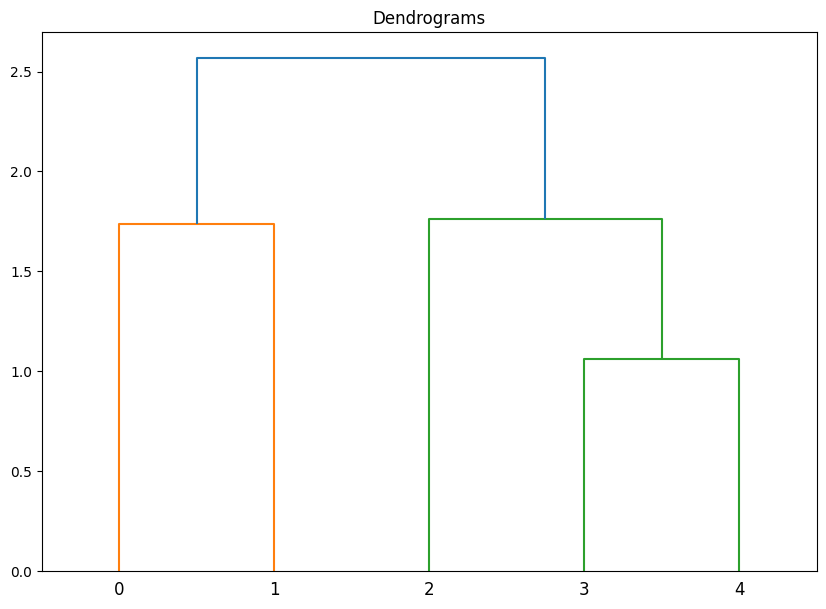

In [22]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")

mergings = shc.linkage(group_cluster5.iloc[:,1:], method='complete')
dend = shc.dendrogram(mergings)

In [31]:
# Klaszterezés a felhasználói értékelések alapján
linkage_matrix = shc.linkage(group_cluster5.iloc[:, 1:], method='complete', metric='euclidean')

# Klaszterek meghatározása
k = 3  # Választhatod más számot is
clusters = shc.fcluster(linkage_matrix, k, criterion='maxclust')

In [32]:
clusters

array([1, 1, 3, 2, 2], dtype=int32)

In [35]:
group_cluster5['cluster_linkage'] = clusters

In [36]:
group_cluster5

,cluster_5,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,...,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir,cluster,cluster_linkage
0,0,-0.625095,0.042997,0.014881,0.079931,-0.052715,0.209076,0.482306,-0.700641,0.249797,...,0.116245,-0.652558,-0.135077,0.032088,0.108469,0.047381,-0.008159,0.043498,1,1
1,1,0.358081,0.320135,0.325462,0.243800,0.324146,0.162940,-0.027692,-0.181340,-0.351493,...,-0.230233,-0.051908,0.048719,0.017280,0.054587,0.164693,0.025654,-0.016335,1,1
2,2,-0.505024,-0.603297,-0.980663,-0.306044,-0.696094,0.043865,0.362382,0.093193,0.272831,...,0.146269,0.076235,-0.083610,0.029332,0.155096,-0.240357,0.027465,0.042447,1,3
3,3,-0.002296,0.002823,-0.006143,0.003826,-0.002071,0.008982,0.001864,-0.006081,0.009114,...,0.006213,0.003102,-0.000002,0.003411,0.005792,-0.000124,0.001072,0.003172,1,2
4,4,0.285066,0.035244,0.000364,-0.581695,0.009722,-0.425574,0.051202,0.374590,0.269160,...,0.200745,0.269889,0.082454,-0.001129,0.025097,-0.051985,0.002349,0.041098,1,2


In [43]:
# "Documentary" kategória kedvelőinek klaszterének meghatározása
documentary_cluster = group_cluster5[group_cluster5['cluster_linkage'] == group_cluster5[group_cluster5['genre_Documentary'] > 0.03]['cluster_linkage'].iloc[0]]

In [47]:
documentary_cluster

,cluster_5,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,...,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir,cluster_linkage
0,0,-0.625095,0.042997,0.014881,0.079931,-0.052715,0.209076,0.482306,-0.700641,0.249797,...,-0.071717,0.116245,-0.652558,-0.135077,0.032088,0.108469,0.047381,-0.008159,0.043498,1
1,1,0.358081,0.320135,0.325462,0.243800,0.324146,0.162940,-0.027692,-0.181340,-0.351493,...,-0.274219,-0.230233,-0.051908,0.048719,0.017280,0.054587,0.164693,0.025654,-0.016335,1


In [39]:
documentary_cluster['cluster'].iloc[0]

1

In [55]:
documentary_cluster.iloc[:, 1:-1]

,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
0,-0.625095,0.042997,0.014881,0.079931,-0.052715,0.209076,0.482306,-0.700641,0.249797,-0.143250,-0.071717,0.116245,-0.652558,-0.135077,0.032088,0.108469,0.047381,-0.008159,0.043498
1,0.358081,0.320135,0.325462,0.243800,0.324146,0.162940,-0.027692,-0.181340,-0.351493,-0.636671,-0.274219,-0.230233,-0.051908,0.048719,0.017280,0.054587,0.164693,0.025654,-0.016335


In [57]:
group_cluster5[group_cluster5['cluster_linkage'] == 2].iloc[:,1 :-1]

,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,genre_Thriller,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir
3,-0.002296,0.002823,-0.006143,0.003826,-0.002071,0.008982,0.001864,-0.006081,0.009114,0.001794,-0.001834,0.006213,0.003102,-0.000002,0.003411,0.005792,-0.000124,0.001072,0.003172
4,0.285066,0.035244,0.000364,-0.581695,0.009722,-0.425574,0.051202,0.374590,0.269160,0.416893,0.014926,0.200745,0.269889,0.082454,-0.001129,0.025097,-0.051985,0.002349,0.041098


In [59]:


# Az összes klaszter és a "Documentary" klaszter közötti hasonlóság számítása
similarities = []
for cluster in range(1, k + 1):
    if cluster == documentary_cluster['cluster_linkage'].iloc[0]:
        continue
    similarity = ((documentary_cluster.iloc[:, 1:-1] - group_cluster5[group_cluster5['cluster_linkage'] == cluster].iloc[:, 1:-1]) ** 2).sum().mean()
    similarities.append((cluster, similarity))

# A legközelebbi klaszter kiválasztása
closest_cluster = min(similarities, key=lambda x: x[1])

# A javasolt kategóriák megjelenítése
suggested_categories = group_cluster5[group_cluster5['cluster_linkage'] == closest_cluster[0]].iloc[:, 1:-1].sum().sort_values(ascending=False).head(3)

# Kíváncsiak lehetünk az eredményre:
print(f"Suggested categories for Documentary lovers: {suggested_categories}")

Suggested categories for Documentary lovers: genre_Thriller     0.418687
genre_Action       0.368509
genre_Adventure    0.282770
dtype: float64


Egy Dokumentumfilm kedvelőnek az alábbi kategóriákat javasolnám:
Thriller, Action, Adventure

Az első klaszterezés alapján a 4. kaszterbe sorolható.
A 4. kategória által nem kedvelt kategóriák: Comedy,	Romance, Musical

Ezek alapján keresek egy alanyt

In [84]:
selected_rows = avg_per_category[(avg_per_category['genre_Documentary'] > 1) & (avg_per_category['cluster_5'] == 4) & ((avg_per_category['genre_Thriller'] == 0) | (avg_per_category['genre_Action'] == 0) | (avg_per_category['genre_Adventure'] == 0) ) & ((avg_per_category['genre_Musical'] < 0) & (avg_per_category['genre_Comedy'] < 0) & (avg_per_category['genre_Romance'] < 0))]


In [87]:
selected_rows

,userId,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,genre_Crime,...,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir,cluster_5
29877,41727,0.0,0.0,0.0,-1.666667,0.0,-1.666667,-1.666667,0.0,0.0,...,0.0,0.333333,0.333333,0.0,1.333333,0.0,-1.666667,0.0,0.0,4


A 41727-es alany megfelelő lesz.

In [89]:
user_ratings = ratings[ratings['userId'] == 41727]

In [90]:
user_ratings

,userId,movieId,rating,timestamp,avg_rating,normalized_rating,norm_avg_rating
345582,41727,5941,2.0,1072693275,3.666667,-1.666667,-0.506918
356189,41727,6303,4.0,1063832143,3.666667,0.333333,0.192163
408550,41727,5669,5.0,1063832318,3.666667,1.333333,0.213632


Az alany által látott filmek: 5941, 6303, 5669
Ezeken kívül keresek olyan flmet, ami a Thriller és/vagy Adventure és/vagy Action kategóriába tartozik. Emellett nem tartozik sem a Romance, Comedy vagy Musical közé.

In [96]:
selected_movies = movies[(movies['genre_Action']==1) & (movies['genre_Adventure']==1) & (movies['genre_Thriller']==1) & (movies['movieId']!=5941)& (movies['movieId']!=6303)& (movies['movieId']!=5669) & (movies['genre_Romance']!=1)& (movies['genre_Musical']!=1)& (movies['genre_Comedy']!=1)& (movies['norm_avg_rating']>0.5) ]

In [97]:
selected_movies

,movieId,title,genres,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,...,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir,norm_avg_rating
5450,6168,10 to Midnight (1983),Action|Adventure|Thriller,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.639231


A 41727-es Id-val rendelkező személynek ajánlanám az 1983-as **10 to Midnight** filmet.
A filmet még nem látta, illetve olyan kategóriába tartozik, amit még nem értékelt.
